# Group 4

### Problem Statement
Given this huge dataset of many various indicators, we would like to use machine learning, to be used on these indicators, that any regular adult can obtain by going through a health screening - to evaluate the risk any given individual has for heart disease.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype
sb.set()

### Import the dataset

In [2]:
df = pd.read_csv('data/heart_2022_no_nans.csv')
# Preliminary check of the data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      246022 non-null  object 
 1   Sex                        246022 non-null  object 
 2   GeneralHealth              246022 non-null  object 
 3   PhysicalHealthDays         246022 non-null  float64
 4   MentalHealthDays           246022 non-null  float64
 5   LastCheckupTime            246022 non-null  object 
 6   PhysicalActivities         246022 non-null  object 
 7   SleepHours                 246022 non-null  float64
 8   RemovedTeeth               246022 non-null  object 
 9   HadHeartAttack             246022 non-null  object 
 10  HadAngina                  246022 non-null  object 
 11  HadStroke                  246022 non-null  object 
 12  HadAsthma                  246022 non-null  object 
 13  HadSkinCancer              24

From the above, we can see that there is a lot of categorical data. A few numerical data, like Height and Weight.

#### Data Cleaning
We would like to first check if the data is clean. We can first check if there exists any rows that has nulls in them.

In [3]:
print(df.isnull().values.any())

False


This tells us that there are no null values in any of the rows in the dataset. This is good. Next, we want to check if there are any odd values in the dataset. We can do this by looking and eyeballing.

In [4]:
for column in df:
    if is_string_dtype(df[column]):
        print(column, df[column].unique())

State ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming' 'Guam' 'Puerto Rico'
 'Virgin Islands']
Sex ['Female' 'Male']
GeneralHealth ['Very good' 'Fair' 'Good' 'Excellent' 'Poor']
LastCheckupTime ['Within past year (anytime less than 12 months ago)'
 '5 or more years ago'
 'Within past 2 years (1 year but less than 2 years ago)'
 'Within past 5 years (2 years but less than 5 years ago)']
PhysicalActivities ['Yes' 'No']
RemovedTeeth ['None of t

We want to check for categorical data, as we will not be able to look for any "odd" values for numerical values until we do some form of analysis. Most of the columns look fine, but there are some weird ones

- HadDiabetes (Yes, but only during pregnancy (female))
- HadDiabetes (No, pre-diabetes or borderline diabetes)
- ECigaretteUsage (Not at all (right now))
- CovidPos (Tested positive using home test without a health professional)

We want to check if these values are significant. If they are not a significant portion of the dataset, looking at these features specifically would not give us any new insights.

In [5]:
print("Had Diabetes : Yes, but only during pregnancy (female) : ", len(df.loc[df['HadDiabetes'] == 'Yes, but only during pregnancy (female)']) / len(df))
print("Had Diabetes : No, pre-diabetes or borderline diabetes : ", len(df.loc[df['HadDiabetes'] == 'No, pre-diabetes or borderline diabetes']) / len(df))
print("ECigaretteUsage : Not at all (right now) : ", len(df.loc[df['ECigaretteUsage'] == 'Not at all (right now)']) / len(df))
print("CovidPos : Tested positive using home test without a health professional: ", len(df.loc[df['CovidPos'] == 'Tested positive using home test without a health professional']) / len(df))

Had Diabetes : Yes, but only during pregnancy (female) :  0.008060254773963304
Had Diabetes : No, pre-diabetes or borderline diabetes :  0.021916739153409043
ECigaretteUsage : Not at all (right now) :  0.17592329141296306
CovidPos : Tested positive using home test without a health professional:  0.034110770581492714


We can see that both options for diabetes is definitely not significant. CovidPos is also not significant as well. The option for ECigarette Usage is very significant, almost 1/5 of the dataset. We will keep that one in.

In [6]:
df['HadDiabetes'] = df['HadDiabetes'].replace('Yes, but only during pregnancy (female)', 'Yes')
df['HadDiabetes'] = df['HadDiabetes'].replace('No, pre-diabetes or borderline diabetes', 'No')
df['CovidPos'] = df['CovidPos'].replace('Tested positive using home test without a health professional', 'Yes')

Check that the replacements are correct.

In [7]:
print(df['HadDiabetes'].unique())
print(df['CovidPos'].unique())

['No' 'Yes']
['No' 'Yes']


In [8]:
df.head(5)

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No


### Exploratory Data Analysis
Given so many variables, the immediate task is to find out which variables are the most meaningful and contribute to the final response (HadHeartAttack). We can first do this by plotting a correlation heatmap, to sieve out what's useful and what's not.

In [9]:
numeric = df.select_dtypes(include = ['int', 'float'])
categorical = df.select_dtypes(include = ['object'])

numeric.set_index(df.index)
numeric['HadHeartAttack'] = df['HadHeartAttack']
numeric.head()

#print("Number of numeric columns: ", len(numeric.columns))
#print("Number of categorical columns: ", len(categorical.columns))

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI,HadHeartAttack
0,4.0,0.0,9.0,1.60,71.67,27.99,No
1,0.0,0.0,6.0,1.78,95.25,30.13,No
2,0.0,0.0,8.0,1.85,108.86,31.66,No
3,5.0,0.0,9.0,1.70,90.72,31.32,No
4,3.0,15.0,5.0,1.55,79.38,33.07,No


## Begin analysis on numeric data

We first plot out the basic data for the numeric columns of this dataset

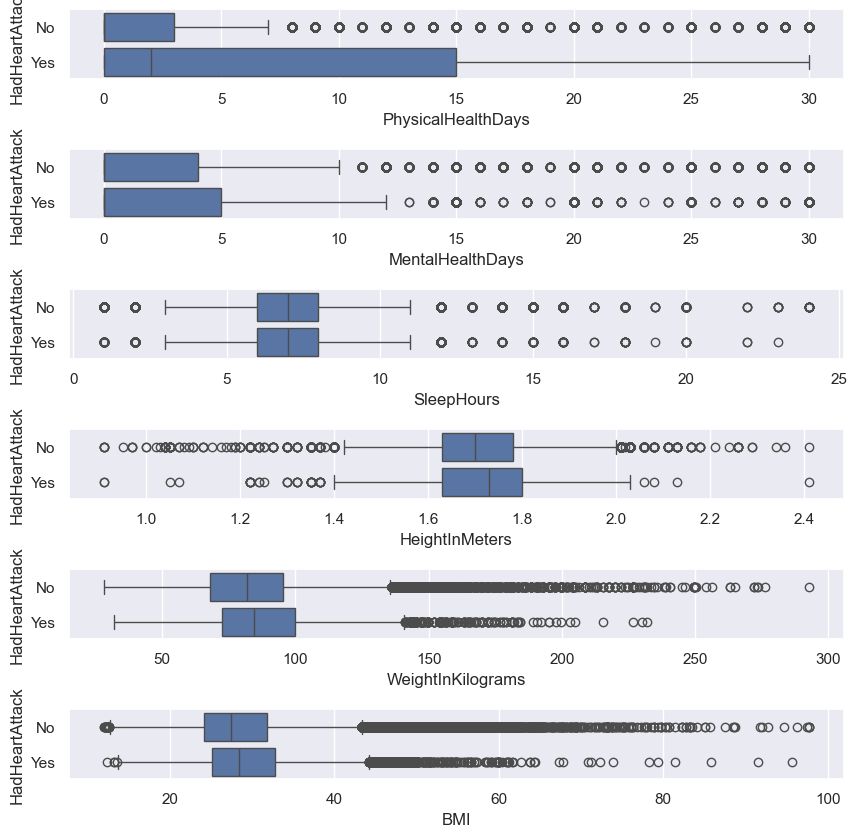

In [13]:
# Draw the distributions of all variables
f, axes = plt.subplots(6, 1, figsize=(10, 10), gridspec_kw={'hspace': 1})
f.subplots_adjust(hspace=0.3, wspace=0.3)

numerical_columns = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI' ]
for i, column in enumerate(numerical_columns):
    sb.boxplot(data = numeric, y='HadHeartAttack', x=column, orient = "h", ax = axes[i], showfliers = True)

## Analysis of numeric data
From the distrbution of numeric data in this dataset, there is no noticeable partitions to help classification with the exception of PhysicalHealthDays.

Moving forward, we can remove **BMI, WeightInKilograms, HeightInMeters, MentalHealthDays** from the classification tree

## Categorical data
We want to check see which categorical variables are best at predicting if a person has some form of heart disease.

In [84]:
# We don't want to include the HadHeartAttack column here as we want to compare against it.
categorical_columns = [col for col in df if is_string_dtype(df[col]) 
                       and col != 'HadHeartAttack'
                       and col != 'State'
                       and col != 'AgeCategory'
                       and col != 'RaceEthnicityCategory']
print(len(categorical_columns), categorical_columns)

30 ['Sex', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities', 'RemovedTeeth', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos']


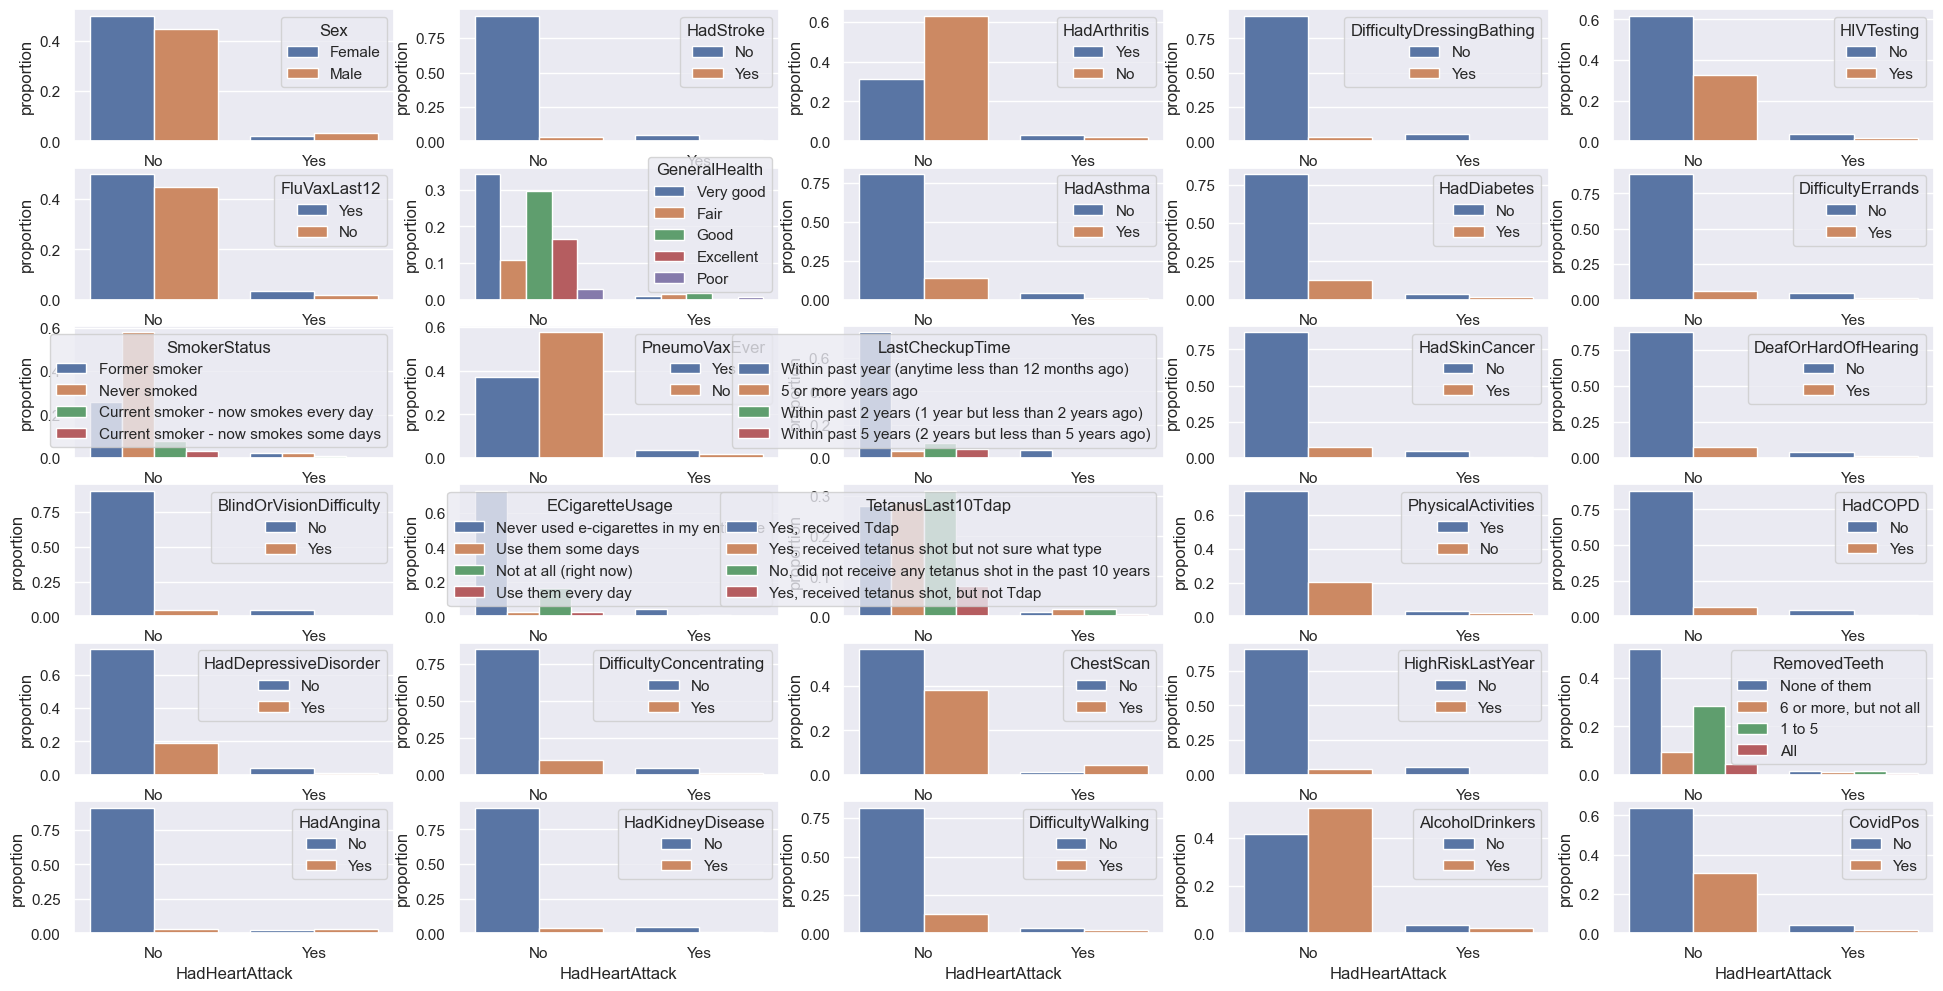

In [87]:
# 30 columns, so lets build 6x5 grid
f, axes = plt.subplots(6, 5, figsize=(24, 12))
for i, col in enumerate(categorical_columns):
    r = int(i % 6)
    c = int(i % 5)
    sb.countplot(pd.concat([df[col], df['HadHeartAttack']], axis=1),
                 x='HadHeartAttack', hue=col, stat='proportion',
                 legend='auto', ax=axes[r][c])